<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
from datetime import datetime, timedelta
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11149

In [3]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [4]:
batches = prepare_batches(all_symbols)

In [5]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1970-01-02,0
1970-01-05,0
1970-01-06,0
1970-01-07,0
1970-01-08,0


In [6]:
states.state.value_counts()

0    3278
2    2540
5    2158
4    1756
1    1595
6    1502
3     535
Name: state, dtype: int64

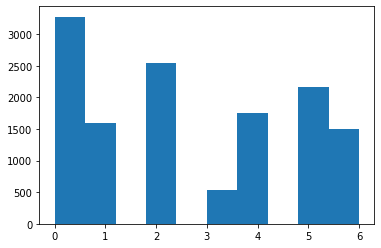

In [7]:
plt.hist(states.state);

In [8]:
TRIM = 0.02
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6]

In [9]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

0

In [10]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [11]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 112


In [12]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 50
MIN_YEARS = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(1973, 1, 5),
 datetime.date(2022, 12, 24),
 datetime.date(2012, 12, 26),
 2)

In [13]:
START, TODAY

(datetime.date(1973, 1, 5), datetime.date(2022, 12, 24))

In [14]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [15]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [16]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [17]:
def filter_by_min_price(data):
    for col in data.columns:
        if (data[col][data[col].notnull()].to_numpy()[-1]
            < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [18]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [19]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [20]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [21]:
def trim_returns(returns, trim):
    lower_q = trim / 2
    upper_q = 1 - lower_q
    qs = np.quantile(returns, q=[lower_q, upper_q])
    returns = returns[((returns > qs[0]) & (returns < qs[1]))]
    return returns

In [22]:
def get_annualized_daily_return(returns, trim=0.02):
    returns = np.array([1] + list((returns[returns.notnull()] + 1).to_numpy()))
    if trim:
        returns = trim_returns(returns, trim)
    amt = returns.cumprod()
    n = len(returns)
    if n > 2:
        daily_return = amt[-1]**(1/max(n - 1, 1))
    else:
        daily_return = 0
    return daily_return

In [23]:
def get_daily_annualized_return_by_state(data, trim=0.02):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        annualized_daily_return = get_annualized_daily_return(returns)
        stock_data.append(annualized_daily_return)
        for state in STATES:
            daily_annualized_return_state = get_annualized_daily_return(
                returns[data.state == state], trim=trim)
            stock_data.append(daily_annualized_return_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['dar'] + [f'dar_{state}' for state in STATES],
        index=stocks)
    return df_out

In [24]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [25]:
def process_batch(batch, min_start, trim=0.02):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    #state_sharpes = get_sharpes_by_state(data)
    #return state_sharpes
    state_dars = get_daily_annualized_return_by_state(data, trim)
    return state_dars

In [26]:
# TODO: multiprocess
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACEL ADUS AGTC ALGS AMK APAC ARES ASTC AUY AZZ BCTF BHK BLL BOXL BSX BZC CBB CDE CFK CIFR CLPT CNL CPAK CRTD CTRA CXH DCNT DIAX DOW DUKB ECOM ELBO ENTX ESP EXAC FCEL FHB FMN FRME FTW GCO GHIX GMRK GRND GWW HDTV HLNE HRMY HYSL IDTI IMMU INVO ISR JE JWN KLXE KVHI LENB LMAT LSPN MANT MDC MGAM MLAB MORF MSNQ MXC NBXZ NFLD NN NSCN NVG OBLG OMN OSAT PAQC PDSN PHAT PLTR PPSI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_50282/1541653759.py:5: RuntimeWarning: divide by zero encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1
/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_50282/1541653759.py:5: RuntimeWarning: invalid value encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1


PSNY PZE RAPT REST RMED RSG SAJA SCMM SFSF SINO SMMF SOLO SRAX STIX SWAG TAYD TETC TKR TPGH TSAT TXCO UMRX UXJ VIFL VOXW VVX WFII WPG XAN XWEL ZKID 

In [27]:
df = pd.concat(dfs, axis=0)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
A,1.000236,0.997810,1.000717,1.029857,1.002045,1.001715,1.002161,1.002138
AA,1.000362,0.997371,1.000912,1.001613,1.000860,1.001167,1.001107,1.001321
AAIC,0.999340,0.997484,0.999857,1.013452,1.002595,1.001375,1.000798,1.000120
AAL,0.999846,0.995377,1.001602,1.016557,1.003688,1.000272,1.001412,1.001952
AAME,0.999728,0.997352,1.000734,1.001073,1.001586,0.999913,1.000938,0.999824


In [28]:
df.tail()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
ZTEK,1.000166,0.999051,0.995952,0.000000,1.007718,1.002511,1.001380,0.998891
ZTR,1.000334,0.999391,1.000562,1.001765,1.000992,1.000633,1.000739,1.000760
ZUMZ,1.000232,0.997466,1.001208,0.974117,1.002803,1.000346,1.001880,1.001185
ZWS,1.000399,0.997099,0.999862,0.000000,1.001480,1.001556,1.001724,1.001755
ZYXI,1.000768,1.000893,1.001467,0.983604,1.002295,0.997663,0.999672,1.003723


In [29]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [30]:
df = pd.read_csv('../data/sharpes_by_state.csv', index_col=0)

In [31]:
CURRENT_STATE# = 0

0

In [32]:
# Weighted Best
# 3: 0.2, 0.6, 0.2
# 2: 0.6, 0.4
#df['weighted'] = {
#    0: 0.6*df.sharpe_0 + 0.4*df.sharpe_1,
#    1: 0.2*df.sharpe_0 + 0.6*df.sharpe_1 + 0.2 * df.sharpe_2
#}[CURRENT_STATE]


if CURRENT_STATE == 0:
    df['weighted'] = (
        0.7*df[f'dar_{CURRENT_STATE}'] 
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.2*df.dar)
elif CURRENT_STATE == 1:
    df['weighted'] = (
        0.6*df[f'dar_{CURRENT_STATE}']
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.1*df[f'dar_{CURRENT_STATE - 1}']
        + 0.2*df.dar)
#elif CURRENT_STATE == ...
elif CURRENT_STATE == 7:
    df['weighted'] = (
        0.3*df[f'dar_{CURRENT_STATE}']
        + 0.5*df[f'dar_{CURRENT_STATE - 1}']
        + 0.2*df.dar)
df = df.sort_values('weighted', ascending=False)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted
GCBC,1.000661,1.001119,1.000486,0.991244,1.000326,1.000235,1.000598,1.000415,1.000964
ZYXI,1.000768,1.000893,1.001467,0.983604,1.002295,0.997663,0.999672,1.003723,1.000925
LFMD,1.000502,1.000538,1.003085,0.000000,1.005390,0.996349,0.999834,0.998905,1.000786
FNV,1.000672,1.000595,1.001078,1.021081,1.000268,1.001120,0.999787,1.000589,1.000659
MTA,1.000327,1.000774,0.999915,0.000000,1.003707,1.000065,0.998138,1.000457,1.000599


In [33]:
df.mean(), df.median()

(dar         1.000129
 dar_0       0.998215
 dar_1       1.000484
 dar_2       0.936261
 dar_3       1.001244
 dar_4       1.001006
 dar_5       1.000984
 dar_6       1.000291
 weighted    0.998825
 dtype: float64,
 dar         1.000284
 dar_0       0.998438
 dar_1       1.000578
 dar_2       1.002575
 dar_3       1.001243
 dar_4       1.001090
 dar_5       1.000983
 dar_6       1.000991
 weighted    0.999034
 dtype: float64)

In [61]:
always_exclude = ['EP', 'NXN', 'NXP']
exclude = {
    0: ['AGNC', 'CGAU', 'CTSH', 'DG', 'ESOA', 'GUT', 'HMY', 'KSM', 'MED', 'MRTI', 'OMQS', 'POOL', 'UTHR', 'ZYXI'],
    1: [],
    7: []}

In [62]:
best_weighted = [
    s for s in df.index
    if s not in exclude[CURRENT_STATE] + always_exclude
][:20]

In [63]:
print(sorted(best_weighted))
#sorted(best_weighted)

['ABST', 'AGI', 'CEF', 'CFFN', 'DGX', 'ERIE', 'FCN', 'FNV', 'FRBA', 'GCBC', 'IEI', 'IIM', 'LFMD', 'MIY', 'MMU', 'MTA', 'NAZ', 'NUO', 'SAL', 'YORW']


In [70]:
DOLLAR_AMT = 100_000
FRAC_IN = 0.61
current = df.loc[best_weighted]
current['w'] = (current.weighted - 1) 
current.w = current.w / current.w.sum()
current['amt'] = (DOLLAR_AMT * FRAC_IN * current.w).round().astype(int)
current

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted,w,amt
GCBC,1.000661,1.001119,1.000486,0.991244,1.000326,1.000235,1.000598,1.000415,1.000964,0.141243,8616
LFMD,1.000502,1.000538,1.003085,0.000000,1.005390,0.996349,0.999834,0.998905,1.000786,0.115096,7021
FNV,1.000672,1.000595,1.001078,1.021081,1.000268,1.001120,0.999787,1.000589,1.000659,0.096497,5886
MTA,1.000327,1.000774,0.999915,0.000000,1.003707,1.000065,0.998138,1.000457,1.000599,0.087724,5351
DGX,1.000671,1.000300,1.000562,0.998954,1.001262,1.001233,1.000708,1.000925,1.000401,0.058712,3581
ABST,1.000353,1.000398,1.000164,0.997245,1.002143,1.000045,0.999296,1.001306,1.000366,0.053577,3268
FCN,1.000735,1.000233,0.999923,1.008816,1.002236,1.001642,1.001248,1.000962,1.000302,0.044296,2702
AGI,1.000542,1.000269,0.999892,1.018285,1.002464,1.001228,0.999651,1.001066,1.000286,0.041911,2557
CEF,1.000154,1.000361,1.000018,1.000685,0.999495,1.000201,1.000011,1.000017,1.000286,0.041838,2552
NAZ,1.000225,1.000173,1.000515,1.000307,1.000098,1.000402,1.000043,1.000069,1.000217,0.031848,1943


In [65]:
data = (
    yf
    .download(best_weighted, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [66]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,ABST,AGI,CEF,CFFN,DGX,ERIE,FCN,FNV,FRBA,GCBC,IEI,IIM,LFMD,MIY,MMU,MTA,NAZ,NUO,SAL,YORW
Date,,,,,,,,,,,,,,,,,,,,
2022-12-19,9.71,9.51,17.420000,8.10,151.449997,271.399994,155.729996,131.850006,13.91,67.599998,116.120003,11.91,2.11,11.03,10.14,4.87,11.34,12.65,30.059999,44.910000
2022-12-20,9.90,9.85,18.100000,8.23,150.199997,274.450012,154.410004,133.050003,13.67,67.050003,115.750000,11.84,2.17,11.04,10.11,5.16,11.28,12.61,29.860001,45.160000
2022-12-21,10.19,10.00,18.110001,8.41,155.300003,281.579987,155.059998,134.759995,13.99,68.400002,115.849998,11.83,2.03,11.13,10.12,5.19,11.32,12.64,31.000000,45.730000
2022-12-22,10.06,10.01,17.740000,8.50,155.630005,276.299988,155.440002,134.600006,13.76,69.400002,115.769997,11.80,2.01,11.09,10.08,5.13,11.29,12.55,30.570000,45.139999
2022-12-23,9.79,9.99,17.820000,8.60,156.309998,276.250000,156.889999,135.850006,14.00,65.400002,115.559998,11.92,2.05,11.06,10.03,5.15,11.30,12.59,31.049999,45.500000


In [67]:
data = pd.concat([data, states], axis=1)

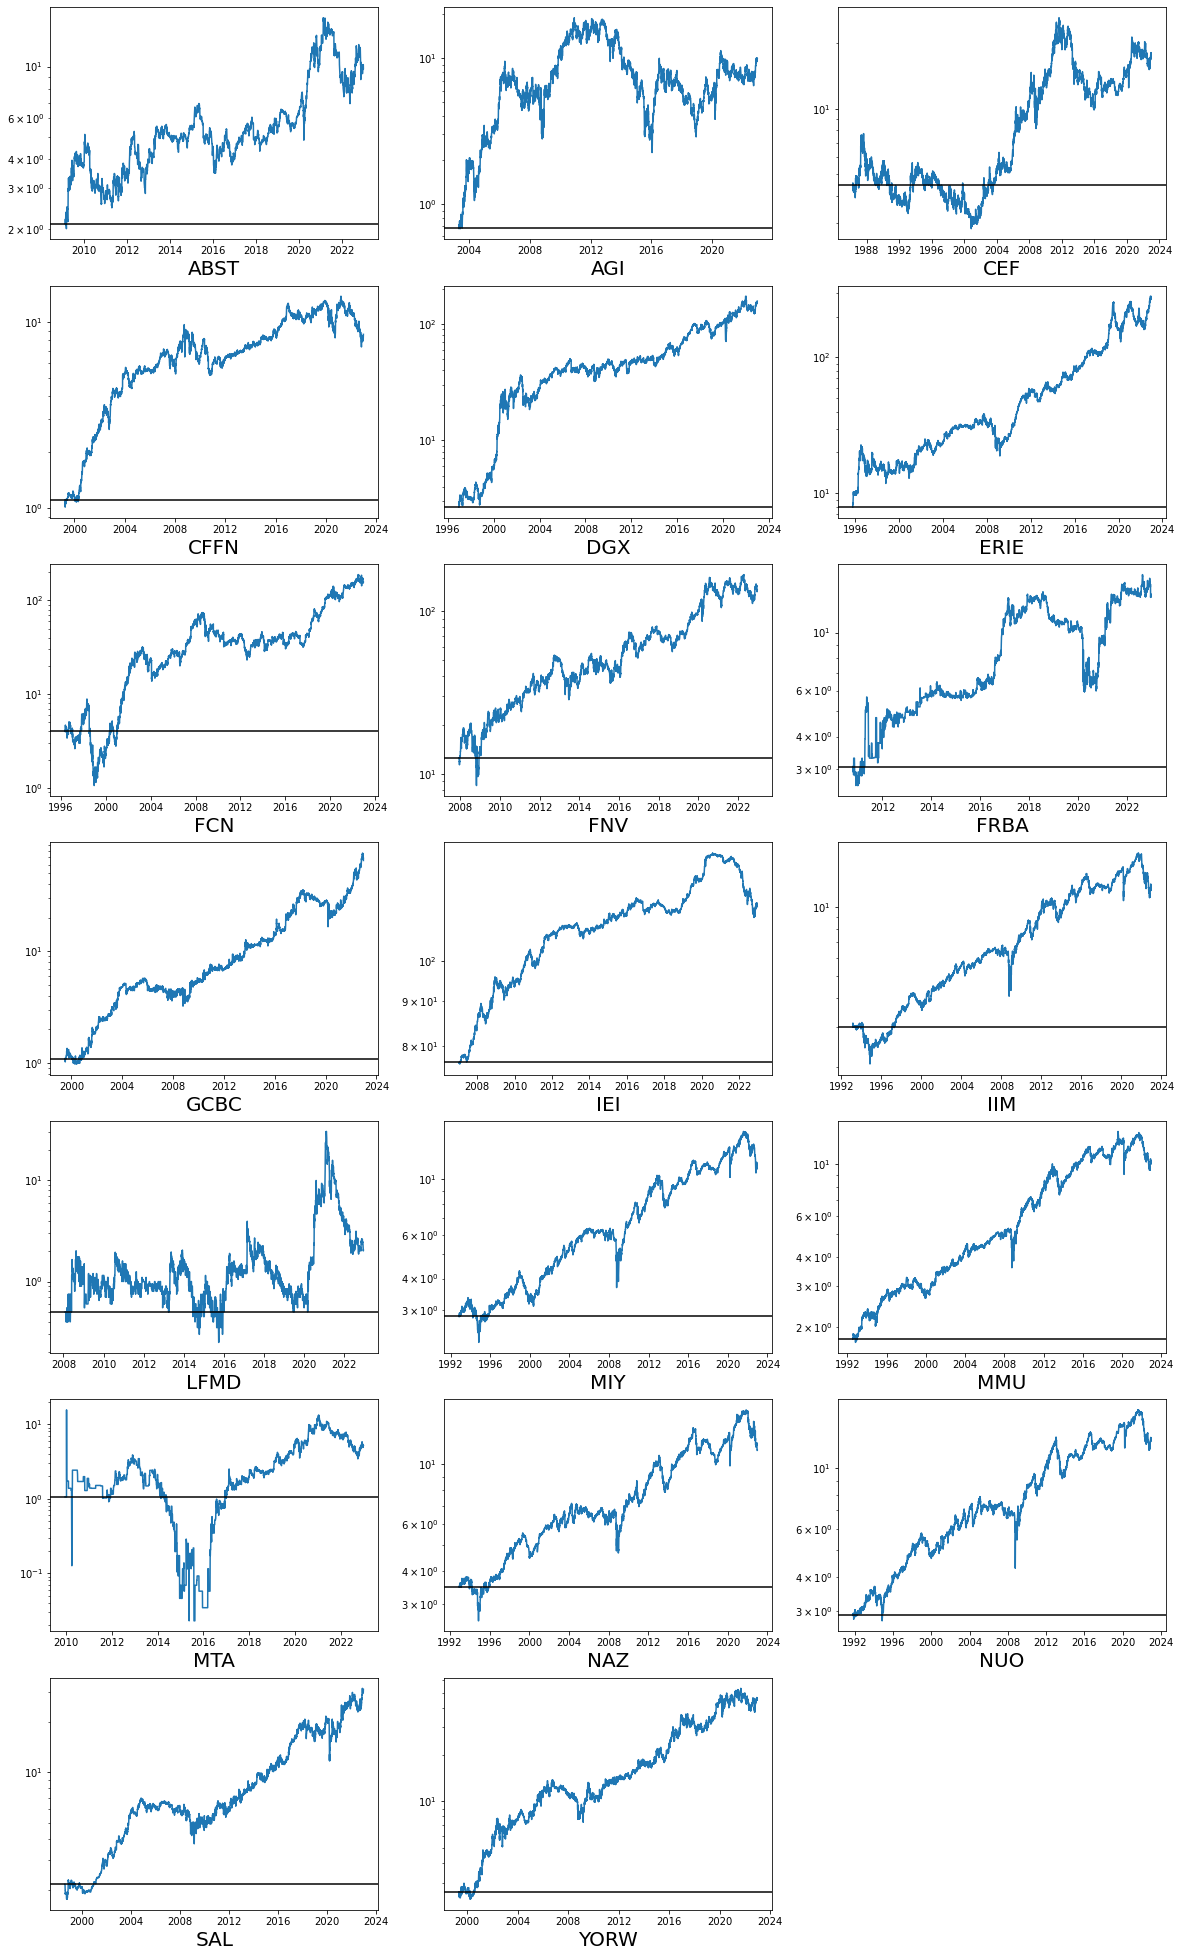

In [68]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    x = data[sym]
    x = x[x.notnull()]
    plt.subplot(7, 3, i + 1)
    plt.plot(x)
    plt.axhline(y=x[0], color='k')
    plt.xlabel(sym)
    plt.yscale('log');

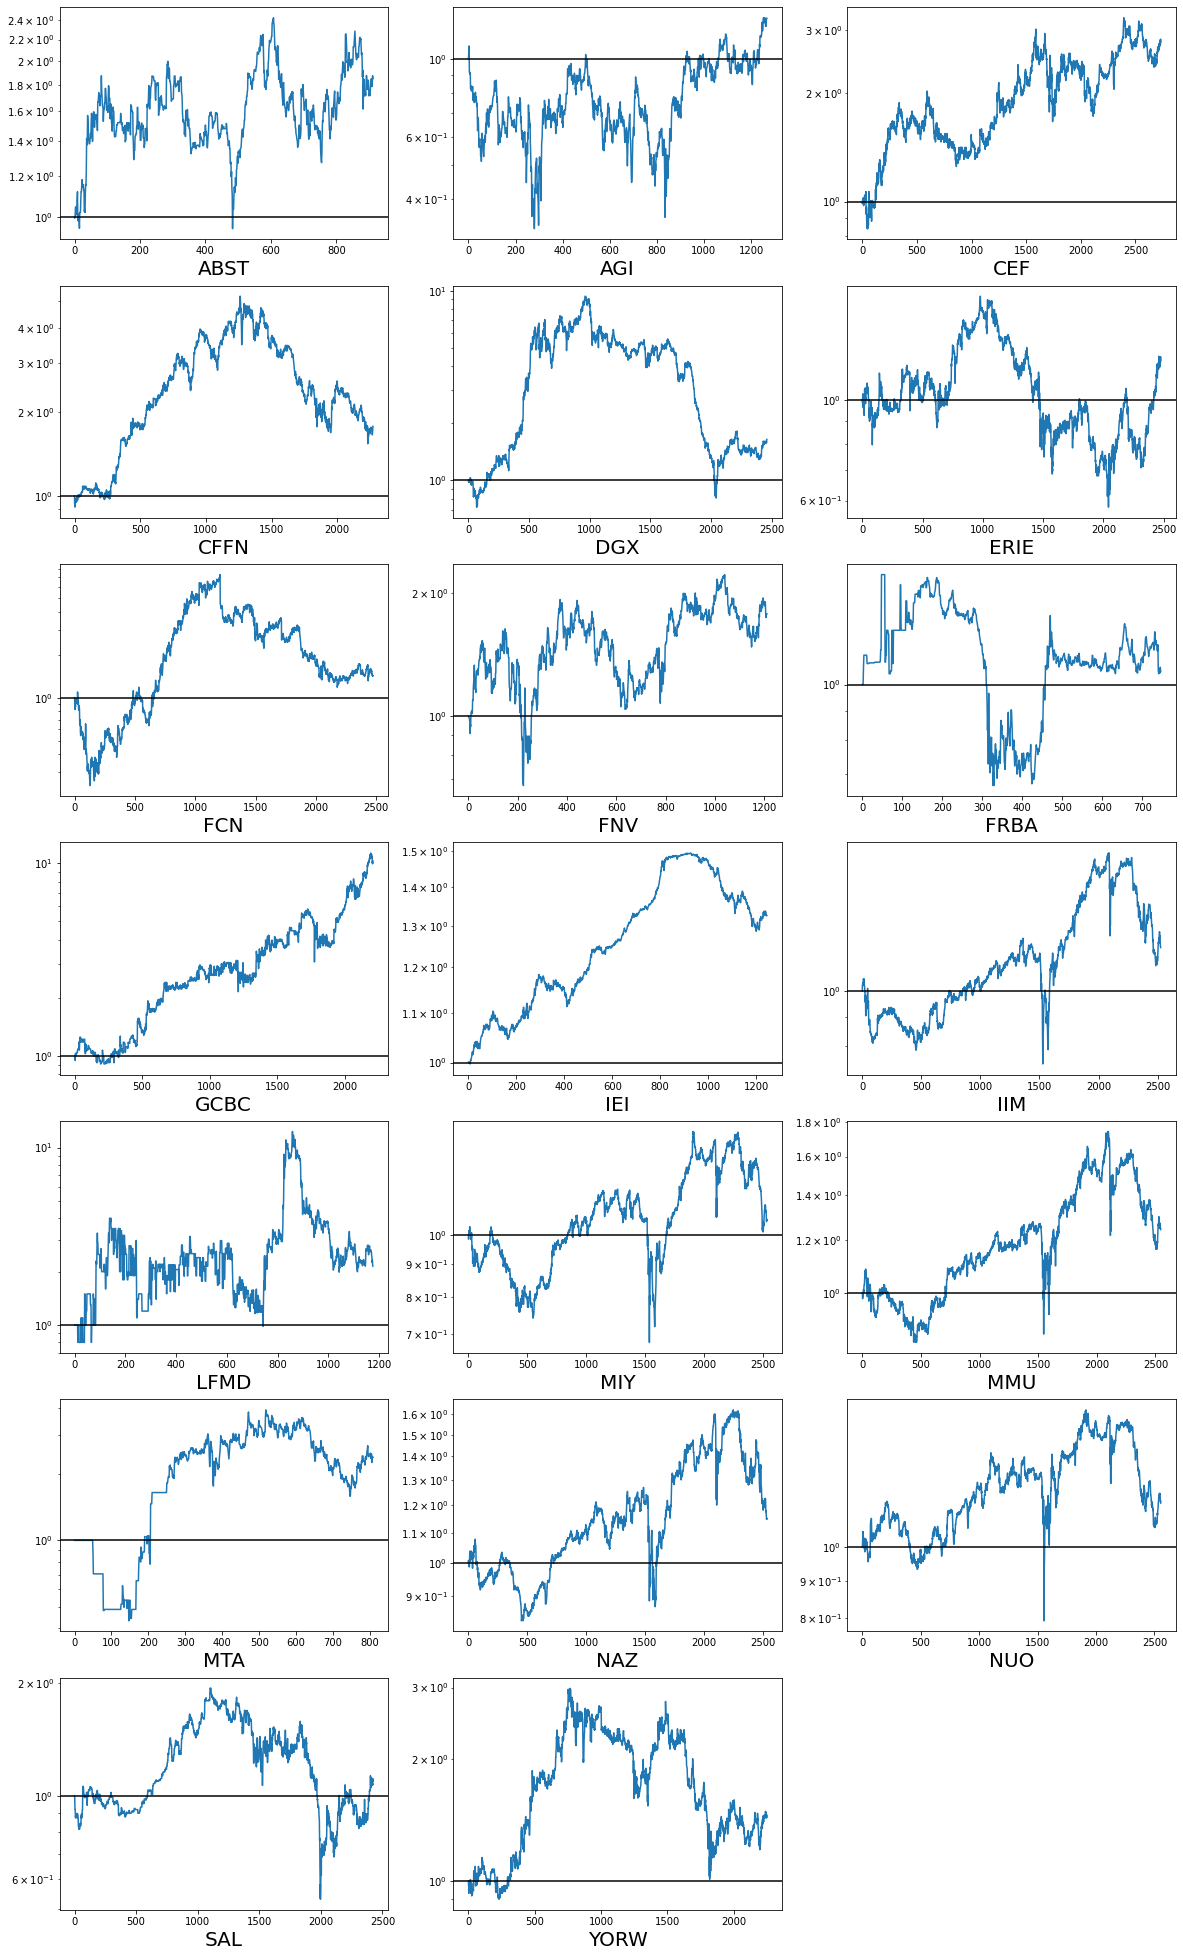

In [69]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    dr = get_daily_returns(data[sym])
    dr = dr[data.state == CURRENT_STATE]
    dr = dr[dr.notnull()]
    dr = (dr + 1).to_numpy()
    dr = np.array([1] + list(dr))
    plt.plot(dr.cumprod())
    plt.axhline(y=dr[0], color='k')
    plt.yscale('log')
    plt.xlabel(sym);